In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read train csv
train_df = pd.concat([pd.read_csv("./Resources/train_2016_v2.csv", parse_dates=["transactiondate"]), 
                      pd.read_csv("./Resources/train_2017.csv", parse_dates=["transactiondate"])])
train_df['transaction_month'] = train_df['transactiondate'].dt.month
prop_df = pd.concat([pd.read_csv("./Resources/properties_2016.csv"), pd.read_csv("./Resources/properties_2016.csv")])
merge_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
col_init = list(merge_df.columns)

/local/home/ningzesun/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# life of property
merge_df['N-life'] = 2018 - merge_df['yearbuilt']
merge_df.drop(['yearbuilt'], axis = 1, inplace = True)
#Ratio of tax of property over parcel
merge_df['N-ValueRatio'] = merge_df['taxvaluedollarcnt']/merge_df['taxamount']
#Number of properties in the zip
zip_count = merge_df['regionidzip'].value_counts().to_dict()
merge_df['N-zip_count'] = merge_df['regionidzip'].map(zip_count)
#error in calculation of the finished living area of home
merge_df['N-LivingAreaError'] = merge_df['calculatedfinishedsquarefeet']/merge_df['finishedsquarefeet12']
# proportion of living area calculated or real
merge_df['N-LivingAreaProp'] = merge_df['calculatedfinishedsquarefeet']/merge_df['lotsizesquarefeet']
merge_df['N-LivingAreaProp2'] = merge_df['finishedsquarefeet12']/merge_df['finishedsquarefeet15']
# Amout of extra space
merge_df['N-ExtraSpace'] = merge_df['lotsizesquarefeet'] - merge_df['calculatedfinishedsquarefeet'] 
merge_df['N-ExtraSpace-2'] = merge_df['finishedsquarefeet15'] - merge_df['finishedsquarefeet12'] 
# Total number of rooms
merge_df['N-TotalRooms'] = merge_df['bathroomcnt'] + merge_df['bedroomcnt']
#Average room size
merge_df['N-AvRoomSize'] = merge_df['calculatedfinishedsquarefeet']/merge_df['roomcnt'] 
# Number of Extra rooms
merge_df['N-ExtraRooms'] = merge_df['roomcnt'] - merge_df['N-TotalRooms']
#Ratio of the built structure value to land area
merge_df['N-ValueProp'] = merge_df['structuretaxvaluedollarcnt']/merge_df['landtaxvaluedollarcnt']

#Does property have a garage, pool or hot tub and AC?
merge_df['N-GarPoolAC'] = ((merge_df['garagecarcnt']>0) & (merge_df['pooltypeid10']>0) \
                           & (merge_df['airconditioningtypeid']!=5))*1 

merge_df["N-location"] = merge_df["latitude"] + merge_df["longitude"]
merge_df["N-location-2"] = merge_df["latitude"]*merge_df["longitude"]


#TotalTaxScore
merge_df['N-TaxScore'] = merge_df['taxvaluedollarcnt']*merge_df['taxamount']

#polnomials of tax delinquency year
merge_df["N-taxdelinquencyyear-2"] = merge_df["taxdelinquencyyear"] ** 2
merge_df["N-taxdelinquencyyear-3"] = merge_df["taxdelinquencyyear"] ** 3

#Length of time since unpaid taxes
merge_df['N-taxdeline-life'] = 2018 - merge_df['taxdelinquencyyear']


#Number of properties in the city
city_count = merge_df['regionidcity'].value_counts().to_dict()
merge_df['N-city_count'] = merge_df['regionidcity'].map(city_count)

#Number of properties in the city
region_count = merge_df['regionidcounty'].value_counts().to_dict()
merge_df['N-county_count'] = merge_df['regionidcounty'].map(city_count)
#Indicator whether it has AC or not
merge_df['N-ACInd'] = (merge_df['airconditioningtypeid']!=5)*1

#Indicator whether it has Heating or not 
merge_df['N-HeatInd'] = (merge_df['heatingorsystemtypeid']!=13)*1

#There's 25 different property uses - let's compress them down to 4 categories
property_dic = {31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 
                260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 
                266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 
                273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 
                291 : "Not Built" }
merge_df['N-PropType'] = merge_df.propertylandusetypeid.replace()
#polnomials of the variable
merge_df["N-structuretaxvaluedollarcnt-2"] = merge_df["structuretaxvaluedollarcnt"] ** 2
merge_df["N-structuretaxvaluedollarcnt-3"] = merge_df["structuretaxvaluedollarcnt"] ** 3

#Average structuretaxvaluedollarcnt by city
group = merge_df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merge_df['N-Avg-structuretaxvaluedollarcnt'] = merge_df['regionidcity'].map(group)

#Deviation away from average
merge_df['N-Dev-structuretaxvaluedollarcnt'] = abs((merge_df['structuretaxvaluedollarcnt'] - \
                                                    merge_df['N-Avg-structuretaxvaluedollarcnt']))/\
                                                    merge_df['N-Avg-structuretaxvaluedollarcnt']

In [4]:
def total_delete(df):
    missing_perc_thresh = 0.98
    delete_missing = []
    num_rows = df.shape[0]
    for i in df.columns:
        num_missing = df[i].isnull().sum()
        missing_perc = num_missing / float(num_rows)
        if missing_perc > missing_perc_thresh:
            delete_missing.append(i)
    delete_unique = []
    for i in df.columns:
        num_uniques = len(df[i].unique())
        if df[i].isnull().sum() != 0:
            num_uniques -= 1
        if num_uniques == 1:
            delete_unique.append(i)
    delete_list = delete_missing
    for i in delete_unique:
        if i not in delete_missing:
            delete_list.append(i)
    return delete_list

In [5]:
delete_other = ['parcelid', 'logerror','propertyzoningdesc', 'transactiondate']
col_init.remove('yearbuilt')

In [6]:
init_drop = total_delete(merge_df[col_init])
init_drop += delete_other
feature_list = [x for x in col_init if x not in init_drop]
add_list = [x for x in list(merge_df.columns) if x not in col_init]
target = merge_df.logerror

In [7]:
from sklearn.preprocessing import LabelEncoder
categories = []
for i in merge_df.columns:
    if merge_df[i].dtype == 'object':
        categories.append(i)
        merge_df[i] = merge_df[i].fillna('NaN')
        le = LabelEncoder()
        merge_df[i] = le.fit_transform(merge_df[i].astype(str))

In [8]:
categories_features = [x for x in categories if x in feature_list]

In [9]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
def run_lgb(new_feature):
    score = 0
    params = {"objective": "regression", "boosting": "gbdt", "num_leaves": 512, "learning_rate": 0.0021,
        'bagging_fraction': 0.85,"colsample_bytree": 0.9, "reg_lambda": 0.1, 'reg_alpha':0.1, "metric": "rmse",
        'max_bins': 10, 'max_depth':-1, 'min_child_sample':20, 'min_child_weight':30,
        'min_split_gain':0.1, 'subsample': 0.9, 'subsample_freq':1,'sub_feature':  0.5}
    kf = KFold(n_splits=3)
    models = []
    features = merge_df[feature_list + new_feature]
    for train_index,test_index in kf.split(features):
        train_features = features.loc[train_index]
        train_target = target.loc[train_index]

        test_features = features.loc[test_index]
        test_target = target.loc[test_index]

        d_training = lgb.Dataset(train_features, label=train_target,
                                 categorical_feature=categories_features, free_raw_data=False)
        d_test = lgb.Dataset(test_features, label=test_target,
                             categorical_feature=categories_features, free_raw_data=False)

        model = lgb.train(params, train_set=d_training, num_boost_round=1000, 
                          valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
        y_pred_valid = model.predict(test_features)
        score += np.sqrt(mean_squared_error(test_target, y_pred_valid)) / 3
    return score

In [10]:
# scores = {'init': 0.16490114941654227}
# for i in add_list:
#     scores[i] = run_lgb([i])

In [11]:
# score_df = pd.DataFrame.from_dict(scores, orient = 'index')
# score_df = score_df.reset_index()
# score_df = score_df.rename(columns = {'index': 'add_feature', 0: 'rmse'})
# score_df.to_csv('./output/add_feature.csv', index = False)

In [12]:
score_df = pd.read_csv('./output/add_feature.csv')

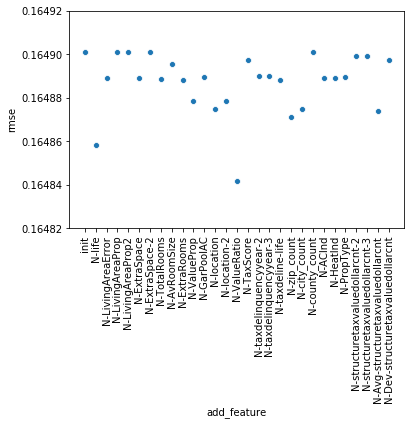

In [14]:
sns.scatterplot(x='add_feature', y='rmse', data=score_df)
plt.ylim(0.16482,0.16492)
plt.xticks(rotation='vertical')
plt.show()

In [18]:
# double_score = run_lgb(['N-life', 'N-ValueRatio'])
# third_score = run_lgb(['N-life', 'N-ValueRatio', 'N-zip_count'])
# fourth_score = run_lgb(['N-life', 'N-ValueRatio', 'N-zip_count', 'N-Avg-structuretaxvaluedollarcnt'])

In [19]:
# score_3 = {'2_scores': double_score, '3_scores': third_score, '4_scores': fourth_score}
# score_3_df = pd.DataFrame.from_dict(score_3, orient = 'index')
# score_3_df = score_3_df.reset_index().rename(columns = {'index': 'add_feature', 0: 'rmse'})
# score_3_df.to_csv('./output/final_add_feature.csv', index = False)

In [20]:
score_3_df = pd.read_csv('./output/final_add_feature.csv')
score_3_df

,add_feature,rmse
0,2_scores,0.164831
1,3_scores,0.164788
2,4_scores,0.164786
